In [229]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import normalize
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import gc #for garbage residue
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn import model_selection, preprocessing, metrics
from sklearn.preprocessing import Imputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import time
from sklearn.metrics import mean_squared_error

Tips for big dataset: 
1. read several lines.
2. change dtype; 
3. Deleting unused variables and gc.collect(); del temp for deleting dataframe of no use anymore;  command: del df followed by gc.collect() But, this seems not releasing space to system. 
4. dask
5. read in chunk
6. using sql. 
7. save dataframe using pickle and load from pickle. 

As for Dask: 
It parallizes NumPy and Pandas operations such as join; makes it possible to work on larger-than-memory datasets; 
limitation: it doesn't have all of Panda's options; many operations that require setting the index are still computationally expensive;
To actually get results of many of the above functions you have to add .compute() at the end

### Facts about the Data: 
#### train and test: card id, feature 1,2 and 3 (are categorical card feature), Target: (loyalty score calculatd 2 month after historical and evaluation period).

#### transaction/3 months' worth of historical transactions for each card_id
flag(authorized or not); card id; city id; categories 1, 2,3; installment (number of installments); merchant_category_id; merchant_id (merchant id); month_lag(month after reference day); purchase_amount (normazlied); purchase_date; state_id; subsector_id(merchant group id). 
#### merchant/additional information about all merchants
merchant_id
merchant_group_id
merchant_category_id
subsector_id
numerical_1
numerical_2
category_1, 2,4
city id and state id,
most_recent_sales_range: range of revenue in last active month
most_recent_purchases_range: range of transaction quantity in last active month
avg_sales_lag3/6/12 (Monthly average of revenue in last 3 months divided by revenue in last active month); avg_purchases_lag3/6/12 (Monthly average of transactions in last 3 months divided by transactions in last active month), active_months_lag3/6/12(quantity of active months in last three months): 

#### new_merchants/ two months' worth of data for each card_id containing ALL purchases that card_id made at merchant_ids that were not visited in the historical data: 
authorized_flag, card_id, city_id, category_1 2 and 3, installments (number of installment), merchant_category_id, merchant_id, month_lag,purchase_amount (normalized), purchase_date, state_id,
subsector_id. 


#### Objective: to understand the most important aspects and preferences in their customers’ lifecycle
#### Evaluation metric: Root Mean Squared Error (RMSE) between predicted loyalty score for each card_id and actual loyalty. 


### Since some csv file is around 3GB. We will consider: reading them using pandas first and conduct data cleaning. The other alternative is to read in dask dataframe. We will consider. After cleaning, we can merge in sqlite. 

In [2]:
train=pd.read_csv('train.csv',nrows=3)
test=pd.read_csv('test.csv',nrows=3)
merchants=pd.read_csv('merchants.csv',nrows=3)
transac= pd.read_csv('historical_transactions.csv', nrows=3)
new_merchant= pd.read_csv('new_merchant_transactions.csv', nrows=3)

In [3]:
allfiles=['train','test','transaction','merchants','new_merchants']
i=0
for item in ([train,test,transac,merchants,new_merchant]):   
    print (allfiles[i])
    display (item.dtypes)
    i+=1

train


first_active_month     object
card_id                object
feature_1               int64
feature_2               int64
feature_3               int64
target                float64
dtype: object

test


first_active_month    object
card_id               object
feature_1              int64
feature_2              int64
feature_3              int64
dtype: object

transaction


authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

merchants


merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
numerical_1                    float64
numerical_2                    float64
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
avg_sales_lag3                 float64
avg_purchases_lag3             float64
active_months_lag3               int64
avg_sales_lag6                 float64
avg_purchases_lag6             float64
active_months_lag6               int64
avg_sales_lag12                float64
avg_purchases_lag12            float64
active_months_lag12              int64
category_4                      object
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

new_merchants


authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
installments              int64
category_3               object
merchant_category_id      int64
merchant_id              object
month_lag                 int64
purchase_amount         float64
purchase_date            object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

Let us cut down the size by changing data subtype: use int8 instead of int 64; float 16 instead of float 64; for object, if we convert them to categoricals, we can even further cut down size; But, we may lose some information. Also, notice that purchase data should be converted to date time even though converting data time can increase size. For large data, it is also useful to use .to_feather to save loaded dataframe. Another approach is to use dask. 

In [4]:
train_dtype={'feature_1':'category','feature_2':'category','feature_3':'category','target':'float16'}
train=pd.read_csv('train.csv',dtype=train_dtype,parse_dates=[0])

In [5]:
test_dtype={'feature_1':'category','feature_2':'category','feature_3':'category','target':'float16'}
test=pd.read_csv('test.csv',dtype=test_dtype,parse_dates=[0])

In [6]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


In [7]:
transac_dtype={'authorized_flag':'category','city_id':'category','category_1':'category','installments ':'int8',
              'category_3':'category','merchant_category_id':'object','month_lag':'int8',
               'purchase_amount':'float16','category_2':'category','state_id':'category','subsector_id':'object'
              }
transac_=pd.read_csv('historical_transactions.csv',dtype=transac_dtype,parse_dates=['purchase_date'])

In [8]:
transac_dtype

{'authorized_flag': 'category',
 'city_id': 'category',
 'category_1': 'category',
 'installments ': 'int8',
 'category_3': 'category',
 'merchant_category_id': 'object',
 'month_lag': 'int8',
 'purchase_amount': 'float16',
 'category_2': 'category',
 'state_id': 'category',
 'subsector_id': 'object'}

In [9]:
merchants_dtype={'merchant_group_id':'object','merchant_category_id':'category','subsector_id':'category',
               'numerical_1':'float16', 'numerical_2':'float16','category_1':'category',
              'most_recent_sales_range':'category','most_recent_purchases_range':'category',
               'avg_sales_lag3':'float16','avg_purchases_lag3':'float16','active_months_lag3':'int8',
               'avg_sales_lag6':'float16','avg_purchases_lag6':'float16','active_months_lag6':'int8',
               'avg_sales_lag12':'float16','avg_purchases_lag12':'float16','active_months_lag12':'int8',
               'category_4':'category','city_id':'category','state_id':'category','category_2':'category'
              }
merchants=pd.read_csv('merchants.csv',dtype=merchants_dtype)


In [10]:
new_merchants_dtype={'authorized_flag':'category','city_id':'category','category_1':'category',
               'installments':'int8', 'category_3':'category', 'merchant_category_id':'category',
                   'month_lag':'int8','purchase_amount':'float16','category_2':'category',
                     'state_id':'category','subsector_id':'category' 
              }
new_merchants=pd.read_csv('new_merchant_transactions.csv',dtype=new_merchants_dtype,parse_dates=['purchase_date'])

### Data Cleaning: 

In [11]:
def dtypes_missing_check(df):
        mis_val = df.isnull().sum()      
        mis_val_percent = (100 * df.isnull().sum() / len(df)).round(1)
        mis_val_table = pd.concat([mis_val,mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns.sort_values(by="% of Total Values",ascending=False)
        return mis_val_table_ren_columns

In [12]:
i=0
names=['train','test','transaction','merchants','new_merchants']
for item in ([train,test,transac_,merchants,new_merchants]):    
    display (names[i])
    display(dtypes_missing_check(item))
    i+=1

'train'

,Missing Values,% of Total Values
first_active_month,0,0.0
card_id,0,0.0
feature_1,0,0.0
feature_2,0,0.0
feature_3,0,0.0
target,0,0.0


'test'

,Missing Values,% of Total Values
first_active_month,1,0.0
card_id,0,0.0
feature_1,0,0.0
feature_2,0,0.0
feature_3,0,0.0


'transaction'

,Missing Values,% of Total Values
category_2,2652864,9.1
category_3,178159,0.6
merchant_id,138481,0.5
authorized_flag,0,0.0
card_id,0,0.0
city_id,0,0.0
category_1,0,0.0
installments,0,0.0
merchant_category_id,0,0.0
month_lag,0,0.0


'merchants'

,Missing Values,% of Total Values
category_2,11887,3.6
merchant_group_id,0,0.0
state_id,0,0.0
city_id,0,0.0
category_4,0,0.0
active_months_lag12,0,0.0
avg_purchases_lag12,0,0.0
avg_sales_lag12,13,0.0
active_months_lag6,0,0.0
avg_purchases_lag6,0,0.0


'new_merchants'

,Missing Values,% of Total Values
category_2,111745,5.7
category_3,55922,2.8
merchant_id,26216,1.3
authorized_flag,0,0.0
card_id,0,0.0
city_id,0,0.0
category_1,0,0.0
installments,0,0.0
merchant_category_id,0,0.0
month_lag,0,0.0


#### Missing values occured in category 2,3 and merchant id. Missing reasons can be: just by random or these merchants do not belong to any category 2 or 3 and they do not have id either.
#### In addition to these missing values, there are some hidden missing values, like -999 and -1. Let us find them out. 

In [13]:
#Visualzation for train: 

In [14]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.687988
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142456
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159790


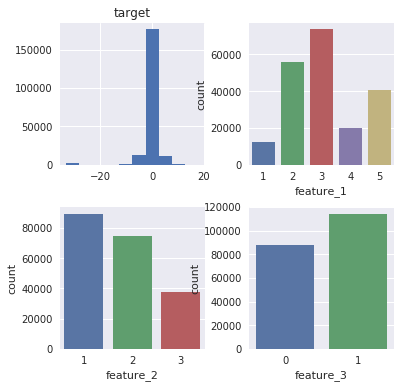

In [15]:
sns.set(rc={'figure.figsize':(6,6)})
f, axes = plt.subplots(2, 2)
train.hist(column='target',ax=axes[0,0])
sns.countplot(train['feature_1'],ax=axes[0,1])
sns.countplot(train['feature_2'],ax=axes[1,0])
sns.countplot(train['feature_3'],ax=axes[1,1])

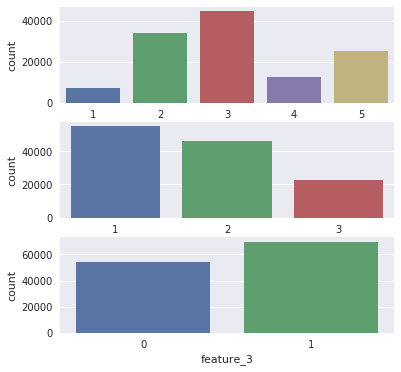

In [16]:
sns.set(rc={'figure.figsize':(6,6)})
f, axes = plt.subplots(3)
sns.countplot(test['feature_1'],ax=axes[0])
sns.countplot(test['feature_2'],ax=axes[1])
sns.countplot(test['feature_3'],ax=axes[2])

#### Note that distribution of levels for feature 1, 2 and 3 appears to be close for train and test set. Also, the train set, target has outliers below -20. 

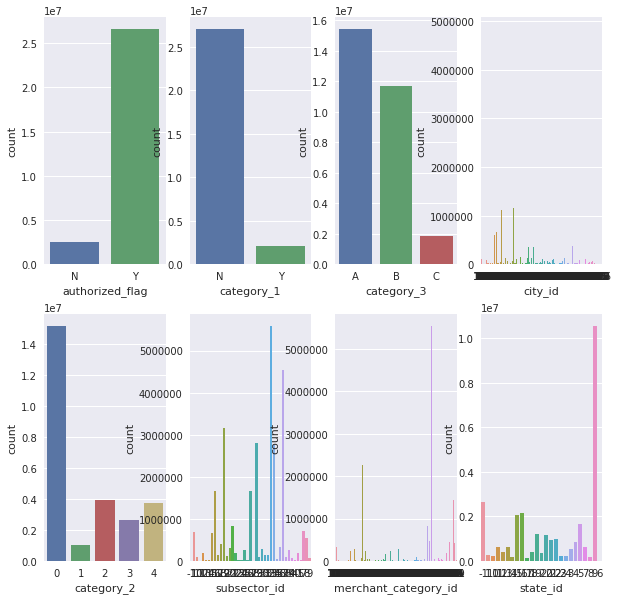

In [17]:
sns.set(rc={'figure.figsize':(10,10)})
f, axes = plt.subplots(2,4)
sns.countplot(transac_['authorized_flag'],ax=axes[0,0])
sns.countplot(transac_['category_1'],ax=axes[0,1])
sns.countplot(transac_['category_3'],ax=axes[0,2])
ax=sns.countplot(transac_['category_2'],ax=axes[1,0])
a=ax.get_xticks().tolist()
a=['0','1','2','3','4']
ax.set_xticklabels(a)
sns.countplot(transac_['city_id'],ax=axes[0,3])
sns.countplot(transac_['subsector_id'],ax=axes[1,1])
sns.countplot(transac_['merchant_category_id'],ax=axes[1,2])
sns.countplot(transac_['state_id'],ax=axes[1,3])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5f1187be0>]],
      dtype=object)

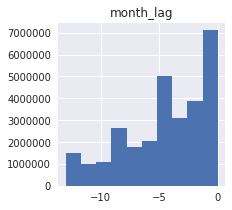

In [18]:
sns.set(rc={'figure.figsize':(3,3)})
transac_.hist(column='month_lag')

#### when trying to visualize each column, I noticed that has some outliers, shown as 999. Also, there are some inf. 

In [19]:
transac_['purchase_amount']=transac_['purchase_amount'].replace([np.inf, -np.inf], np.nan)
transac_['purchase_amount'].describe()

count    2.911231e+07
mean              NaN
std               NaN
min     -7.470703e-01
25%     -7.202148e-01
50%     -6.884766e-01
75%     -6.030273e-01
max      6.476800e+04
Name: purchase_amount, dtype: float64

count    2.911236e+07
mean     6.484954e-01
std      2.795577e+00
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      9.990000e+02
Name: installments, dtype: float64

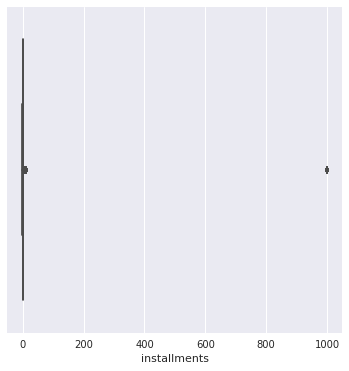

In [20]:
sns.set(rc={'figure.figsize':(6,6)})
display(transac_['installments'].describe()) 
sns.boxplot(transac_['installments'])

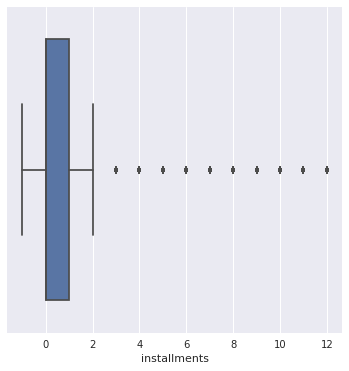

In [21]:
sns.set(rc={'figure.figsize':(6,6)})
transac_['installments']=transac_['installments'].replace([999], np.nan)
transac_['installments'].describe
sns.boxplot(transac_['installments'])

Let us visualize the two columns. 
Purchase amount is very skewed as seen in previous description. Let us visualize it in log scale instead. 


In [22]:
transac_.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0.0,A,80,M_ID_e020e9b302,-8,-0.703125,2017-06-25 15:33:07,1.00000000,16,37
1,Y,C_ID_4e6213e9bc,88,N,0.0,A,367,M_ID_86ec983688,-7,-0.732910,2017-07-15 12:10:45,1.00000000,16,16
2,Y,C_ID_4e6213e9bc,88,N,0.0,A,80,M_ID_979ed661fc,-6,-0.720215,2017-08-09 22:04:29,1.00000000,16,37
3,Y,C_ID_4e6213e9bc,88,N,0.0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.00000000,16,34
4,Y,C_ID_4e6213e9bc,88,N,0.0,A,80,M_ID_e020e9b302,-11,-0.722656,2017-03-10 01:14:19,1.00000000,16,37


In [23]:
np.sum(transac_['purchase_amount']==0)

10

In [24]:
nonzero=transac_.loc[transac_['purchase_amount']!=0,'purchase_amount']

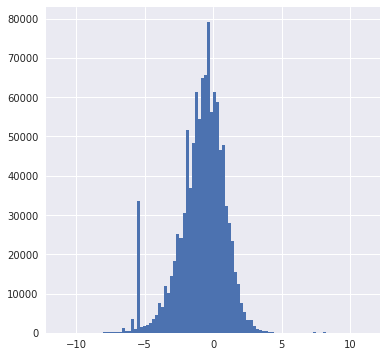

In [25]:
log_purch=nonzero.apply(np.log);
plt.hist(log_purch.dropna(), bins=100);

#### Looks like log tranformation of purchase_amount makes the distribution much more normal;

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff5d4de1c18>]],
      dtype=object)

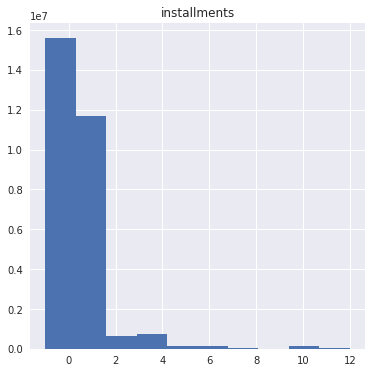

In [26]:
sns.set(rc={'figure.figsize':(6,6)})
transac_.hist(['installments'])

#### Besides, some id are -1, which are also NAs as you can see below.

In [27]:
transac_.loc[transac_['city_id']=='-1',:].head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
11,Y,C_ID_4e6213e9bc,-1,N,0.0,A,560,M_ID_7c5e93af2f,0,-0.728027,2018-02-08 20:05:45,NaN,-1,34
30,Y,C_ID_4e6213e9bc,-1,N,0.0,A,80,M_ID_98b342c0e3,0,-0.724609,2018-02-27 09:04:48,NaN,-1,37
43,Y,C_ID_4e6213e9bc,-1,N,0.0,A,278,NaN,0,-0.719238,2018-02-24 10:52:32,NaN,-1,37
80,Y,C_ID_4e6213e9bc,-1,N,0.0,A,80,M_ID_98b342c0e3,0,-0.724609,2018-02-23 09:20:59,NaN,-1,37
82,Y,C_ID_4e6213e9bc,-1,N,0.0,A,278,NaN,0,-0.713379,2018-02-25 12:07:37,NaN,-1,37


In [28]:
transac_['city_id']=transac_['city_id'].replace(['-1'], np.nan)
transac_['merchant_category_id']=transac_['merchant_category_id'].replace(['-1'], np.nan)
transac_['state_id']=transac_['state_id'].replace(['-1'], np.nan)
transac_['subsector_id']=transac_['subsector_id'].replace(['-1'], np.nan)
transac_['card_id']=transac_['card_id'].replace(['-1'], np.nan)

In [29]:
transac_=transac_.dropna()

In [30]:
transac_.dtypes

authorized_flag               category
card_id                         object
city_id                       category
category_1                    category
installments                   float64
category_3                    category
merchant_category_id            object
merchant_id                     object
month_lag                         int8
purchase_amount                float16
purchase_date           datetime64[ns]
category_2                    category
state_id                      category
subsector_id                    object
dtype: object

In [31]:
transac_['installments']=transac_['installments'].astype('int8')

### Below, we continue with data cleaning for merchnant file.

In [32]:
merchants.columns

Index(['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2'],
      dtype='object')

#### There are some ids are -1 as well:

In [33]:
merchants.loc[merchants['merchant_category_id']=='-1',:]

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
2465,M_ID_a2cfe4149a,35,-1,-1,-0.047546,-0.047546,N,E,E,1.0,...,1.0,1.166992,2,1.0,1.166992,2,N,231,9,1.00000000


In [34]:
merchants['merchant_group_id']=merchants['merchant_group_id'].replace(['-1'], np.nan)
merchants['merchant_category_id']=merchants['merchant_category_id'].replace(['-1'], np.nan)
merchants['subsector_id']=merchants['subsector_id'].replace(['-1'], np.nan)
merchants['city_id']=merchants['city_id'].replace(['-1'], np.nan)
merchants['state_id']=merchants['state_id'].replace(['-1'], np.nan)

In [35]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.399902,...,-2.250000,18.671875,6,-2.320312,13.914062,12,N,242,9,1.00000000
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720215,...,-0.740234,1.291992,6,-0.569824,1.687500,12,N,22,16,1.00000000
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.125000,...,-82.125000,260.000000,2,-82.125000,260.000000,2,N,NaN,5,5.00000000
3,M_ID_a70e9c5f81,5026,792,9,-0.057465,-0.057465,Y,E,E,NaN,...,NaN,4.667969,6,NaN,3.833984,12,Y,NaN,NaN,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057465,-0.057465,Y,E,E,NaN,...,NaN,0.361084,6,NaN,0.347168,12,Y,NaN,NaN,NaN


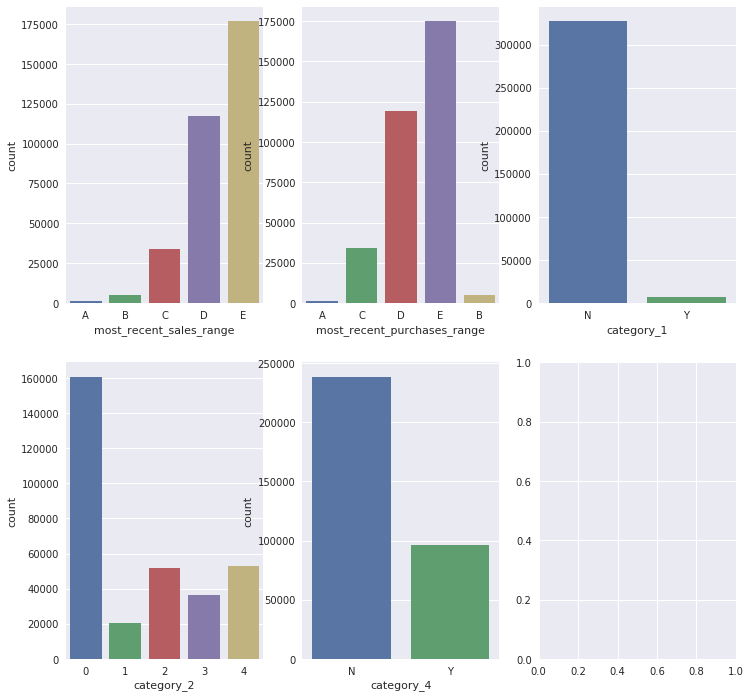

In [36]:
sns.set(rc={'figure.figsize':(12,12)})
f, axes = plt.subplots(2,3)
sns.countplot(merchants['most_recent_sales_range'],ax=axes[0,0])
sns.countplot(merchants['most_recent_purchases_range'],ax=axes[0,1])
sns.countplot(merchants['category_1'],ax=axes[0,2])
ax=sns.countplot(merchants['category_2'],ax=axes[1,0])
a=ax.get_xticks().tolist()
a=['0','1','2','3','4']
ax.set_xticklabels(a)
sns.countplot(merchants['category_4'],ax=axes[1,1])

#### below are quantitative variables we want to take a look. 

In [37]:
display(merchants['numerical_1'].describe())
display(merchants['numerical_2'].describe())
display(merchants['avg_sales_lag3'].describe())
display(merchants['avg_purchases_lag3'].describe())
display(merchants['active_months_lag3'].describe())

display(merchants['avg_sales_lag6'].describe())
display(merchants['avg_purchases_lag6'].describe())
display(merchants['active_months_lag6'].describe())
display(merchants['avg_sales_lag3'].describe())

display(merchants['avg_purchases_lag12'].describe())
display(merchants['active_months_lag12'].describe())


count    334696.000000
mean          0.011482
std           0.000000
min          -0.057465
25%          -0.057465
50%          -0.057465
75%          -0.047546
max         183.750000
Name: numerical_1, dtype: float64

count    334696.000000
mean          0.008095
std           0.000000
min          -0.057465
25%          -0.057465
50%          -0.057465
75%          -0.047546
max         182.125000
Name: numerical_2, dtype: float64

count    3.346830e+05
mean              NaN
std               NaN
min     -8.212500e+01
25%      8.798828e-01
50%      1.000000e+00
75%      1.160156e+00
max               inf
Name: avg_sales_lag3, dtype: float64

count    3.346960e+05
mean              NaN
std               NaN
min      3.334961e-01
25%      9.238281e-01
50%      1.016602e+00
75%      1.146484e+00
max               inf
Name: avg_purchases_lag3, dtype: float64

count    334696.000000
mean          2.994108
std           0.095247
min           1.000000
25%           3.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: active_months_lag3, dtype: float64

count    3.346830e+05
mean              NaN
std               NaN
min     -8.212500e+01
25%      8.500977e-01
50%      1.009766e+00
75%      1.230469e+00
max               inf
Name: avg_sales_lag6, dtype: float64

count    3.346960e+05
mean              NaN
std               NaN
min      1.669922e-01
25%      9.023438e-01
50%      1.027344e+00
75%      1.215820e+00
max               inf
Name: avg_purchases_lag6, dtype: float64

count    334696.000000
mean          5.947397
std           0.394936
min           1.000000
25%           6.000000
50%           6.000000
75%           6.000000
max           6.000000
Name: active_months_lag6, dtype: float64

count    3.346830e+05
mean              NaN
std               NaN
min     -8.212500e+01
25%      8.798828e-01
50%      1.000000e+00
75%      1.160156e+00
max               inf
Name: avg_sales_lag3, dtype: float64

count    3.346960e+05
mean              NaN
std               NaN
min      9.832764e-02
25%      8.984375e-01
50%      1.042969e+00
75%      1.266602e+00
max               inf
Name: avg_purchases_lag12, dtype: float64

count    334696.000000
mean         11.599335
std           1.520138
min           1.000000
25%          12.000000
50%          12.000000
75%          12.000000
max          12.000000
Name: active_months_lag12, dtype: float64

#### From above, numerical_1 and numerical_2 are very skewed and there are some inf values that need to be fixed.  

In [38]:
merchants['avg_sales_lag3']=merchants['avg_sales_lag3'].replace([np.inf, -np.inf], np.nan)
merchants['avg_purchases_lag3']=merchants['avg_purchases_lag3'].replace([np.inf, -np.inf], np.nan)
merchants['active_months_lag3']=merchants['active_months_lag3'].replace([np.inf, -np.inf], np.nan)

merchants['avg_sales_lag6']=merchants['avg_sales_lag6'].replace([np.inf, -np.inf], np.nan)
merchants['avg_purchases_lag6']=merchants['avg_purchases_lag6'].replace([np.inf, -np.inf], np.nan)
merchants['active_months_lag6']=merchants['active_months_lag6'].replace([np.inf, -np.inf], np.nan)

merchants['avg_sales_lag12']=merchants['avg_sales_lag12'].replace([np.inf, -np.inf], np.nan)
merchants['avg_purchases_lag12']=merchants['avg_purchases_lag12'].replace([np.inf, -np.inf], np.nan)
merchants['active_months_lag12']=merchants['active_months_lag12'].replace([np.inf, -np.inf], np.nan)


In [39]:
display(sum(merchants['numerical_1']==0))
display(sum(merchants['numerical_2']==0))

0

0

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


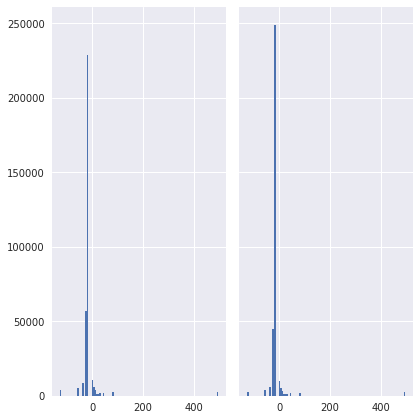

In [40]:
sns.set(rc={'figure.figsize':(6,6)})
temp1=1/merchants['numerical_1']
temp2=1/merchants['numerical_2']
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True);
axs[0].hist(temp1,bins=100);
axs[1].hist(temp2,bins=100);

#### Log transformation helps visualization of its distribution. Here, after transformation, it is still very skewed though. 

In [41]:
display(merchants['avg_sales_lag3'].describe())
display(merchants['avg_purchases_lag3'].describe())
display(merchants['active_months_lag3'].describe())

display(merchants['avg_sales_lag6'].describe())
display(merchants['avg_purchases_lag6'].describe())
display(merchants['active_months_lag6'].describe())
display(merchants['avg_sales_lag3'].describe())

display(merchants['avg_purchases_lag12'].describe())
display(merchants['active_months_lag12'].describe())

count    334671.000000
mean               NaN
std                NaN
min         -82.125000
25%           0.879883
50%           1.000000
75%           1.160156
max       44448.000000
Name: avg_sales_lag3, dtype: float64

count    334693.000000
mean               NaN
std                NaN
min           0.333496
25%           0.923828
50%           1.016602
75%           1.146484
max       61856.000000
Name: avg_purchases_lag3, dtype: float64

count    334696.000000
mean          2.994108
std           0.095247
min           1.000000
25%           3.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: active_months_lag3, dtype: float64

count    334670.000000
mean               NaN
std                NaN
min         -82.125000
25%           0.850098
50%           1.009766
75%           1.230469
max       55776.000000
Name: avg_sales_lag6, dtype: float64

count    334693.000000
mean               NaN
std                NaN
min           0.166992
25%           0.902344
50%           1.027344
75%           1.215820
max       56064.000000
Name: avg_purchases_lag6, dtype: float64

count    334696.000000
mean          5.947397
std           0.394936
min           1.000000
25%           6.000000
50%           6.000000
75%           6.000000
max           6.000000
Name: active_months_lag6, dtype: float64

count    334671.000000
mean               NaN
std                NaN
min         -82.125000
25%           0.879883
50%           1.000000
75%           1.160156
max       44448.000000
Name: avg_sales_lag3, dtype: float64

count    334693.000000
mean               NaN
std                NaN
min           0.098328
25%           0.898438
50%           1.042969
75%           1.266602
max       50208.000000
Name: avg_purchases_lag12, dtype: float64

count    334696.000000
mean         11.599335
std           1.520138
min           1.000000
25%          12.000000
50%          12.000000
75%          12.000000
max          12.000000
Name: active_months_lag12, dtype: float64

#### Notice that these columns are very skewed. 

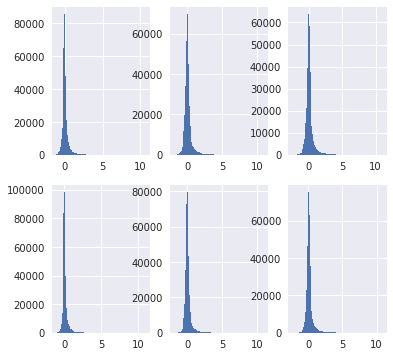

In [42]:
f, axes = plt.subplots(2,3)
log_sale_3=merchants['avg_sales_lag3'].apply(np.log) 
log_sale_6=merchants['avg_sales_lag6'].apply(np.log) 
log_sale_12=merchants['avg_sales_lag12'].apply(np.log) 

log_purch_3=merchants['avg_purchases_lag3'].apply(np.log) 
log_purch_6=merchants['avg_purchases_lag6'].apply(np.log) 
log_purch_12=merchants['avg_purchases_lag12'].apply(np.log) 

axes[0,0].hist(log_sale_3.dropna(), bins=100);
axes[0,1].hist(log_sale_6.dropna(), bins=100);
axes[0,2].hist(log_sale_12.dropna(), bins=100);

axes[1,0].hist(log_purch_3.dropna(), bins=100);
axes[1,1].hist(log_purch_6.dropna(), bins=100);
axes[1,2].hist(log_purch_12.dropna(), bins=100);


In [43]:
del log_sale_3
del log_sale_6
del log_sale_12
del log_purch_3
del log_purch_6
del log_purch_12

In [44]:
merchants=merchants.dropna()

In [46]:
merchants['active_months_lag3']=merchants['active_months_lag3'].astype('int8')
merchants['active_months_lag6']=merchants['active_months_lag6'].astype('int8')
merchants['active_months_lag12']=merchants['active_months_lag12'].astype('int8')

#### Transformation helps visualization of average sale and average purchase, but not active month. But, from descr() function, active_month column should be cleaned. 

### Continue with data cleaning for new_merchants file

In [47]:
new_merchants.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.00000000,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.00000000,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.00000000,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671875,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659668,2018-03-22 21:07:53,NaN,-1,29


In [48]:
new_merchants['city_id']=new_merchants['city_id'].replace(['-1'], np.nan)
new_merchants['merchant_category_id']=new_merchants['merchant_category_id'].replace(['-1'], np.nan)
new_merchants['state_id']=new_merchants['state_id'].replace(['-1'], np.nan)
new_merchants['subsector_id']=new_merchants['subsector_id'].replace(['-1'], np.nan)

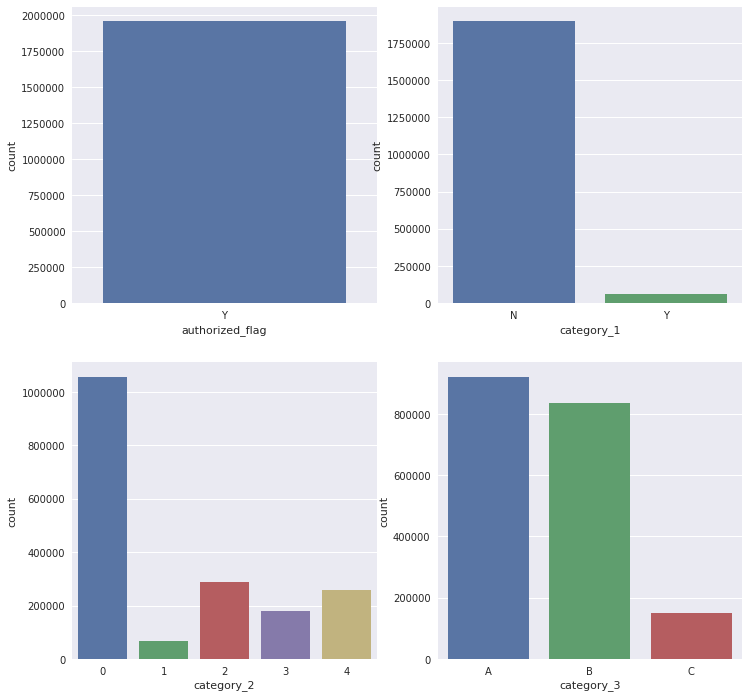

In [49]:
sns.set(rc={'figure.figsize':(12,12)})
f, axes = plt.subplots(2,2)
sns.countplot(new_merchants['authorized_flag'],ax=axes[0,0])
sns.countplot(new_merchants['category_1'],ax=axes[0,1])
ax=sns.countplot(new_merchants['category_2'],ax=axes[1,0])
a=ax.get_xticks().tolist()
a=['0','1','2','3','4']
ax.set_xticklabels(a)
sns.countplot(new_merchants['category_3'],ax=axes[1,1])

In [50]:
new_merchants=new_merchants.drop(columns='authorized_flag',axis=1)

In [51]:
display(new_merchants['installments'].describe())
display(new_merchants['month_lag'].describe())
display(new_merchants['purchase_amount'].describe())

count    1.963031e+06
mean     6.819210e-01
std      1.222513e+00
min     -2.500000e+01
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.200000e+01
Name: installments, dtype: float64

count    1.963031e+06
mean     1.476515e+00
std      4.994483e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: month_lag, dtype: float64

count    1.963031e+06
mean              NaN
std               NaN
min     -7.470703e-01
25%     -7.167969e-01
50%     -6.748047e-01
75%     -5.815430e-01
max      2.632500e+02
Name: purchase_amount, dtype: float64

In [52]:
display(sum(new_merchants['installments']==0))
display(sum(new_merchants['purchase_amount']==0))

922244

0

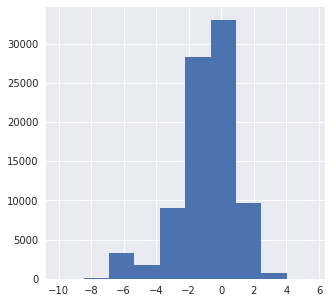

In [53]:
sns.set(rc={'figure.figsize':(5,5)})
new_merchants['purchase_amount'].apply(np.log).dropna().hist();

In [54]:
new_merchants=new_merchants.dropna()

In [1]:
## Here is to understand how data is gnerated: 

In [57]:
display(train['first_active_month'].min())
display(train['first_active_month'].max())
display(transac_['purchase_date'].min())
display(transac_['purchase_date'].max())
display(new_merchants['purchase_date'].min())
display(new_merchants['purchase_date'].max())

Timestamp('2011-11-01 00:00:00')

Timestamp('2018-02-01 00:00:00')

Timestamp('2017-01-01 00:00:08')

Timestamp('2018-02-28 23:59:49')

Timestamp('2017-03-01 03:24:51')

Timestamp('2018-04-30 23:59:59')

## Feature engineering: 

In [58]:
#the cateogry 1, 2, and 3 should refer to type of transaction rather than category of merchans. 
def agg_card(df): 
    df['purch_mon']=df['purchase_date'].dt.month
    df['purch_mon_sin'] = np.sin((df.purch_mon-1)*(2.*np.pi/12))
    df['purch_mon_cos'] = np.cos((df.purch_mon-1)*(2.*np.pi/12))
    df['authorized_flag']=1 if 'Y' else 0
    temp=df.groupby(['card_id'],as_index=False).agg({
    "purchase_date":['count','max','min'],
    "purch_mon_sin":['max','min','std'], 
    "purch_mon_cos":['max','min','std'],
    "purchase_amount":['sum','mean','std','max','min'],
    "installments":['sum','mean','std','max','min'],
    "authorized_flag":'mean',
    "state_id": ['nunique',(lambda x:x.value_counts().index[0])],
    "city_id": ['nunique',(lambda x:x.value_counts().index[0])],
    "category_1": ['nunique',(lambda x:x.value_counts().index[0])],
    "category_2": ['nunique',(lambda x:x.value_counts().index[0])],
    "category_3": ['nunique',(lambda x:x.value_counts().index[0])]}) 
    temp.columns= ['_'.join(col).strip() for col in temp.columns.values]    
    temp['history_range']=temp['purchase_date_max']-temp['purchase_date_min']
    temp['purch_sin_range']=temp['purch_mon_sin_max']-temp['purch_mon_sin_min']
    temp['purch_cos_range']=temp['purch_mon_cos_max']-temp['purch_mon_cos_min']
    temp['purch_sin_freq']=temp['purchase_date_count']/temp['purch_sin_range']
    temp['purch_cos_freq']=temp['purchase_date_count']/temp['purch_cos_range']
    return temp

In [168]:
t_g_C=agg_card(transac_)

In [170]:
t_g_C.to_pickle('./t_g_C.pkl')

In [57]:
t_g_C=pd.read_pickle('./t_g_C.pkl')

In [59]:
t_g_c_new=agg_card(new_merchants)

In [60]:
t_g_c_new.to_pickle('./t_g_c_new.pkl')

In [58]:
t_g_c_new=pd.read_pickle('./t_g_c_new.pkl')

In [59]:
t_g_C['purch_sin_freq']=t_g_C['purch_sin_freq'].replace([np.inf, -np.inf], 0)
t_g_C['purch_cos_freq']=t_g_C['purch_cos_freq'].replace([np.inf, -np.inf], 0)
t_g_c_new['purch_sin_freq']=t_g_c_new['purch_sin_freq'].replace([np.inf, -np.inf], 0)
t_g_c_new['purch_cos_freq']=t_g_c_new['purch_cos_freq'].replace([np.inf, -np.inf], 0)

In [60]:
compare=pd.merge(t_g_C,t_g_c_new,how='left', left_on=['card_id_'], right_on=['card_id_'])

In [61]:
cat_temp=compare.loc[:,compare.dtypes==('object' or 'category')]
compare_temp=compare.loc[:,compare.dtypes!=('object' or 'category')]

In [62]:
def diff(df,col_index):
    for item in col_index: 
        df[df.columns[item].replace('_x','')+'dif']=df[df.columns[item]]-df[df.columns[item].replace('_x','')+'_y']
    return df

In [63]:
t_g_C_new_dif=diff(compare_temp,range(30)) 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [64]:
t_g_C_new_dif_comb=pd.merge(cat_temp, t_g_C_new_dif, left_index=True, right_index=True)

In [65]:
def successive_agg_c(df, field1, field2):
    temp1=df.groupby([field1,field2],as_index=False).agg({
    "purchase_date":['count',(lambda x: (x.max()-x.min()))],
    "purchase_amount":['sum'],
    "category_1": ['nunique'],
    "category_2": ['nunique'],
    "category_3": ['nunique'], 
    "merchant_category_id":['nunique'],
    "installments": ['mean']})
        
    temp1.columns= ['_'.join(col).strip() for col in temp1.columns.values]
    temp1['purchase_date_<lambda>']=(temp1['purchase_date_<lambda>']).dt.days
    temp1['purchase_date_count_fre']=temp1['purchase_date_count']/temp1['purchase_date_<lambda>']
    temp1['purchase_amount_fre']=temp1['purchase_amount_sum']/temp1['purchase_date_<lambda>']
    temp1['purchase_date_count_fre']=temp1['purchase_date_count_fre'].replace([np.inf, -np.inf], 0)
    temp1['purchase_amount_fre']=temp1['purchase_amount_fre'].replace([np.inf, -np.inf], 0)
    print (temp1.columns)
    temp2=temp1.groupby(['card_id_'],as_index=False).agg({
    "merchant_id_":['nunique'],
    "purchase_date_count": ['max','min','mean'],
    "purchase_date_<lambda>": ['max','min','mean'],  
    "purchase_amount_sum":['max','min','std','mean'],
    "category_1_nunique": ['mean'],
    "category_2_nunique": ['mean'],
    "category_3_nunique": ['mean'],    
    "merchant_category_id_nunique":['mean'],
    "installments_mean": ['max','min','std','mean'],
     'purchase_date_count_fre': ['max','min','std','mean'],
     'purchase_amount_fre': ['max','min','std','mean']   
    })
    temp2.columns= ['_'.join(col).strip() for col in temp2.columns.values]
    temp2.columns = ['agg_c' + '_'+ col for col in temp2.columns.values]
    return temp2

In [270]:
t_g_m_c=successive_agg_c(transac_,'card_id','merchant_id')

Index(['card_id_', 'merchant_id_', 'purchase_date_count',
       'purchase_date_<lambda>', 'purchase_amount_sum', 'category_1_nunique',
       'category_2_nunique', 'category_3_nunique',
       'merchant_category_id_nunique', 'installments_mean',
       'purchase_date_count_fre', 'purchase_amount_fre'],
      dtype='object')


In [273]:
t_g_m_c.to_pickle('./t_g_m_c.pkl')

In [66]:
t_g_m_c=pd.read_pickle('./t_g_m_c.pkl')

In [67]:
t_g_new_c=successive_agg_c(new_merchants,'card_id','merchant_id')

Index(['card_id_', 'merchant_id_', 'purchase_date_count',
       'purchase_date_<lambda>', 'purchase_amount_sum', 'category_1_nunique',
       'category_2_nunique', 'category_3_nunique',
       'merchant_category_id_nunique', 'installments_mean',
       'purchase_date_count_fre', 'purchase_amount_fre'],
      dtype='object')


In [275]:
t_g_new_c.to_pickle('./t_g_new_c.pkl')

In [68]:
t_g_new_c=pd.read_pickle('./t_g_new_c.pkl')

In [69]:
compare2=pd.merge(t_g_m_c,t_g_new_c,how='left', left_on=['agg_c_card_id__'], right_on=['agg_c_card_id__'])

In [70]:
cat_temp2=compare2.loc[:,compare2.dtypes==('object' or 'category')]
compare2_temp=compare2.loc[:,compare2.dtypes!=('object' or 'category')]


In [71]:
t_g_C_new_dif2=diff(compare2_temp,range(27))

In [72]:
t_g_C_new_dif_comb2=pd.merge(cat_temp2, t_g_C_new_dif2, left_index=True, right_index=True)

In [77]:
def add_agg(df, field1, field2):
    t = df.groupby(['card_id', field1],as_index=False).agg({field2:['mean']})
    t.columns =['card_id',field1,field2]
    u = t.groupby('card_id',as_index=False).agg({field2:['mean', 'min', 'max', 'std']})
    u.columns =['card_id',field1+field2+'mean',field1+field2+'min',field1+field2+'max',field1+field2+'std']
    return u

In [78]:
add_t2 = add_agg(transac_,'category_2','purchase_amount')
add_t3 = add_agg(transac_,'category_3','purchase_amount')

add_t=pd.merge(add_t2,add_t3,how='left', left_on=['card_id'], right_on=['card_id'])

In [79]:
add_n2 = add_agg(new_merchants,'category_2','purchase_amount')
add_n3 = add_agg(new_merchants,'category_3','purchase_amount')

add_n=pd.merge(add_n2,add_n3,how='left', left_on=['card_id'], right_on=['card_id'])

In [80]:
compare_add=pd.merge(add_t,add_n,how='left', left_on=['card_id'], right_on=['card_id'])


In [81]:
compare_add1=compare_add.drop(columns=['card_id'])

In [82]:
add_dif2=diff(compare_add1,range(8))

In [83]:
add_dif2['card_id']=compare_add['card_id']

In [190]:
def build_set(df):
    comb_card1=pd.merge(df,t_g_C_new_dif_comb,how='left', left_on=['card_id'], right_on=['card_id_'])
    comb_card2=pd.merge(comb_card1,t_g_C_new_dif_comb2,how='left', left_on=['card_id'], right_on=['agg_c_card_id__'])
    comb_card3=pd.merge(comb_card2,add_dif2,how='left', left_on=['card_id'], right_on=['card_id'])
    comb_card3['active_lag']=(comb_card3['first_active_month']-comb_card3['purchase_date_min_x']).dt.days
    comb_card3['is_active_recent']=(comb_card3['purchase_date_max_y']-max(comb_card3['purchase_date_max_y'])).dt.days
    sets=comb_card3.drop(['card_id','card_id_','agg_c_card_id__','category_1_<lambda>_x','category_1_<lambda>_y'], axis=1)
    
    sets.loc[sets['category_3_<lambda>_x']=='A','category_3_<lambda>_x']=1
    sets.loc[sets['category_3_<lambda>_x']=='B','category_3_<lambda>_x']=2
    sets.loc[sets['category_3_<lambda>_x']=='C','category_3_<lambda>_x']=3
    sets.loc[sets['category_3_<lambda>_y']=='A','category_3_<lambda>_y']=1
    sets.loc[sets['category_3_<lambda>_y']=='B','category_3_<lambda>_y']=2
    sets.loc[sets['category_3_<lambda>_y']=='C','category_3_<lambda>_y']=3
    sets['history_range_x']=sets['history_range_x'].dt.days
    sets['history_range_y']=sets['history_range_y'].dt.days
    sets['purchase_date_maxdif']=sets['purchase_date_maxdif'].dt.days
    sets['purchase_date_mindif']=sets['purchase_date_mindif'].dt.days
    sets['history_rangedif']=sets['history_rangedif'].dt.days
    return sets

In [310]:
train_set=build_set(train)
test_set=build_set(test)

In [311]:
train_set=train_set.drop(columns=['first_active_month','purchase_date_max_x','purchase_date_min_x','purchase_date_max_y','purchase_date_min_y','city_id_<lambda>_y','city_id_<lambda>_x','state_id_<lambda>_x','state_id_<lambda>_y'])
test_set=test_set.drop(columns=['first_active_month','purchase_date_max_x','purchase_date_min_x','purchase_date_max_y','purchase_date_min_y','city_id_<lambda>_y','city_id_<lambda>_x','state_id_<lambda>_x','state_id_<lambda>_y'])

In [312]:
catcol=['feature_1','feature_2','feature_3',
    'category_2_<lambda>_x','category_3_<lambda>_x',
    'category_2_<lambda>_y','category_3_<lambda>_y']

In [313]:
for col in catcol: 
    train_set[col] = train_set[col].astype('category')
    test_set[col] = test_set[col].astype('category')

In [314]:
features=[c for c in train_set.columns if c not in ['target']]
target=train_set['target']

In [334]:
def run_cv(select_features): 
    param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 1,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train_set))
    predictions = np.zeros(len(test_set))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_set.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train_set.iloc[trn_idx][select_features], label=target.iloc[trn_idx],
                              categorical_feature=catcol)
                
    
        val_data = lgb.Dataset(train_set.iloc[val_idx][select_features], label=target.iloc[val_idx],
                               categorical_feature=catcol)
                    

        num_round = 10000
        clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data,val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
        oof[val_idx] = clf.predict(train_set.iloc[val_idx][select_features], num_iteration=clf.best_iteration)
    
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = select_features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
        predictions += clf.predict(test_set[features], num_iteration=clf.best_iteration) / folds.n_splits
    print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))
    return feature_importance_df,predictions


In [319]:
feature_importance_df,predictions=run_cv(features)

fold n°0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75747	valid_1's rmse: 3.81695
[200]	training's rmse: 3.70805	valid_1's rmse: 3.78627
[300]	training's rmse: 3.67486	valid_1's rmse: 3.77199
[400]	training's rmse: 3.65019	valid_1's rmse: 3.76496
[500]	training's rmse: 3.63085	valid_1's rmse: 3.76163
[600]	training's rmse: 3.61547	valid_1's rmse: 3.75959
[700]	training's rmse: 3.60252	valid_1's rmse: 3.75831
[800]	training's rmse: 3.59095	valid_1's rmse: 3.75758
[900]	training's rmse: 3.5803	valid_1's rmse: 3.75754
[1000]	training's rmse: 3.57037	valid_1's rmse: 3.75749
[1100]	training's rmse: 3.56137	valid_1's rmse: 3.75782
Early stopping, best iteration is:
[995]	training's rmse: 3.57092	valid_1's rmse: 3.75744
fold n°1


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.77398	valid_1's rmse: 3.74524
[200]	training's rmse: 3.7236	valid_1's rmse: 3.71837
[300]	training's rmse: 3.68914	valid_1's rmse: 3.70636
[400]	training's rmse: 3.66348	valid_1's rmse: 3.70017
[500]	training's rmse: 3.6434	valid_1's rmse: 3.69706
[600]	training's rmse: 3.62675	valid_1's rmse: 3.69532
[700]	training's rmse: 3.61315	valid_1's rmse: 3.69416
[800]	training's rmse: 3.60162	valid_1's rmse: 3.69349
[900]	training's rmse: 3.59014	valid_1's rmse: 3.69316
[1000]	training's rmse: 3.57956	valid_1's rmse: 3.69292
[1100]	training's rmse: 3.56995	valid_1's rmse: 3.69287
[1200]	training's rmse: 3.56103	valid_1's rmse: 3.69288
Early stopping, best iteration is:
[1078]	training's rmse: 3.5718	valid_1's rmse: 3.69274
fold n°2


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.78068	valid_1's rmse: 3.71675
[200]	training's rmse: 3.73025	valid_1's rmse: 3.68861
[300]	training's rmse: 3.69637	valid_1's rmse: 3.67555
[400]	training's rmse: 3.67102	valid_1's rmse: 3.66918
[500]	training's rmse: 3.65156	valid_1's rmse: 3.66616
[600]	training's rmse: 3.63567	valid_1's rmse: 3.66456
[700]	training's rmse: 3.62236	valid_1's rmse: 3.66373
[800]	training's rmse: 3.6099	valid_1's rmse: 3.6632
[900]	training's rmse: 3.59895	valid_1's rmse: 3.6632
[1000]	training's rmse: 3.58873	valid_1's rmse: 3.66316
[1100]	training's rmse: 3.57895	valid_1's rmse: 3.66323
[1200]	training's rmse: 3.57051	valid_1's rmse: 3.66368
Early stopping, best iteration is:
[1036]	training's rmse: 3.58517	valid_1's rmse: 3.66306
fold n°3


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72964	valid_1's rmse: 3.92333
[200]	training's rmse: 3.67989	valid_1's rmse: 3.89566
[300]	training's rmse: 3.64617	valid_1's rmse: 3.88279
[400]	training's rmse: 3.62091	valid_1's rmse: 3.8774
[500]	training's rmse: 3.6009	valid_1's rmse: 3.87479
[600]	training's rmse: 3.58447	valid_1's rmse: 3.87364
[700]	training's rmse: 3.57074	valid_1's rmse: 3.87292
[800]	training's rmse: 3.55813	valid_1's rmse: 3.87294
[900]	training's rmse: 3.54723	valid_1's rmse: 3.87276
Early stopping, best iteration is:
[743]	training's rmse: 3.5646	valid_1's rmse: 3.87272
fold n°4


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.77464	valid_1's rmse: 3.73633
[200]	training's rmse: 3.72339	valid_1's rmse: 3.71252
[300]	training's rmse: 3.68875	valid_1's rmse: 3.70195
[400]	training's rmse: 3.66281	valid_1's rmse: 3.69744
[500]	training's rmse: 3.64274	valid_1's rmse: 3.69535
[600]	training's rmse: 3.62577	valid_1's rmse: 3.69435
[700]	training's rmse: 3.61212	valid_1's rmse: 3.69379
[800]	training's rmse: 3.59976	valid_1's rmse: 3.6936
[900]	training's rmse: 3.58881	valid_1's rmse: 3.69355
[1000]	training's rmse: 3.57819	valid_1's rmse: 3.69378
Early stopping, best iteration is:
[878]	training's rmse: 3.5914	valid_1's rmse: 3.69347
CV score: 3.73664 


/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


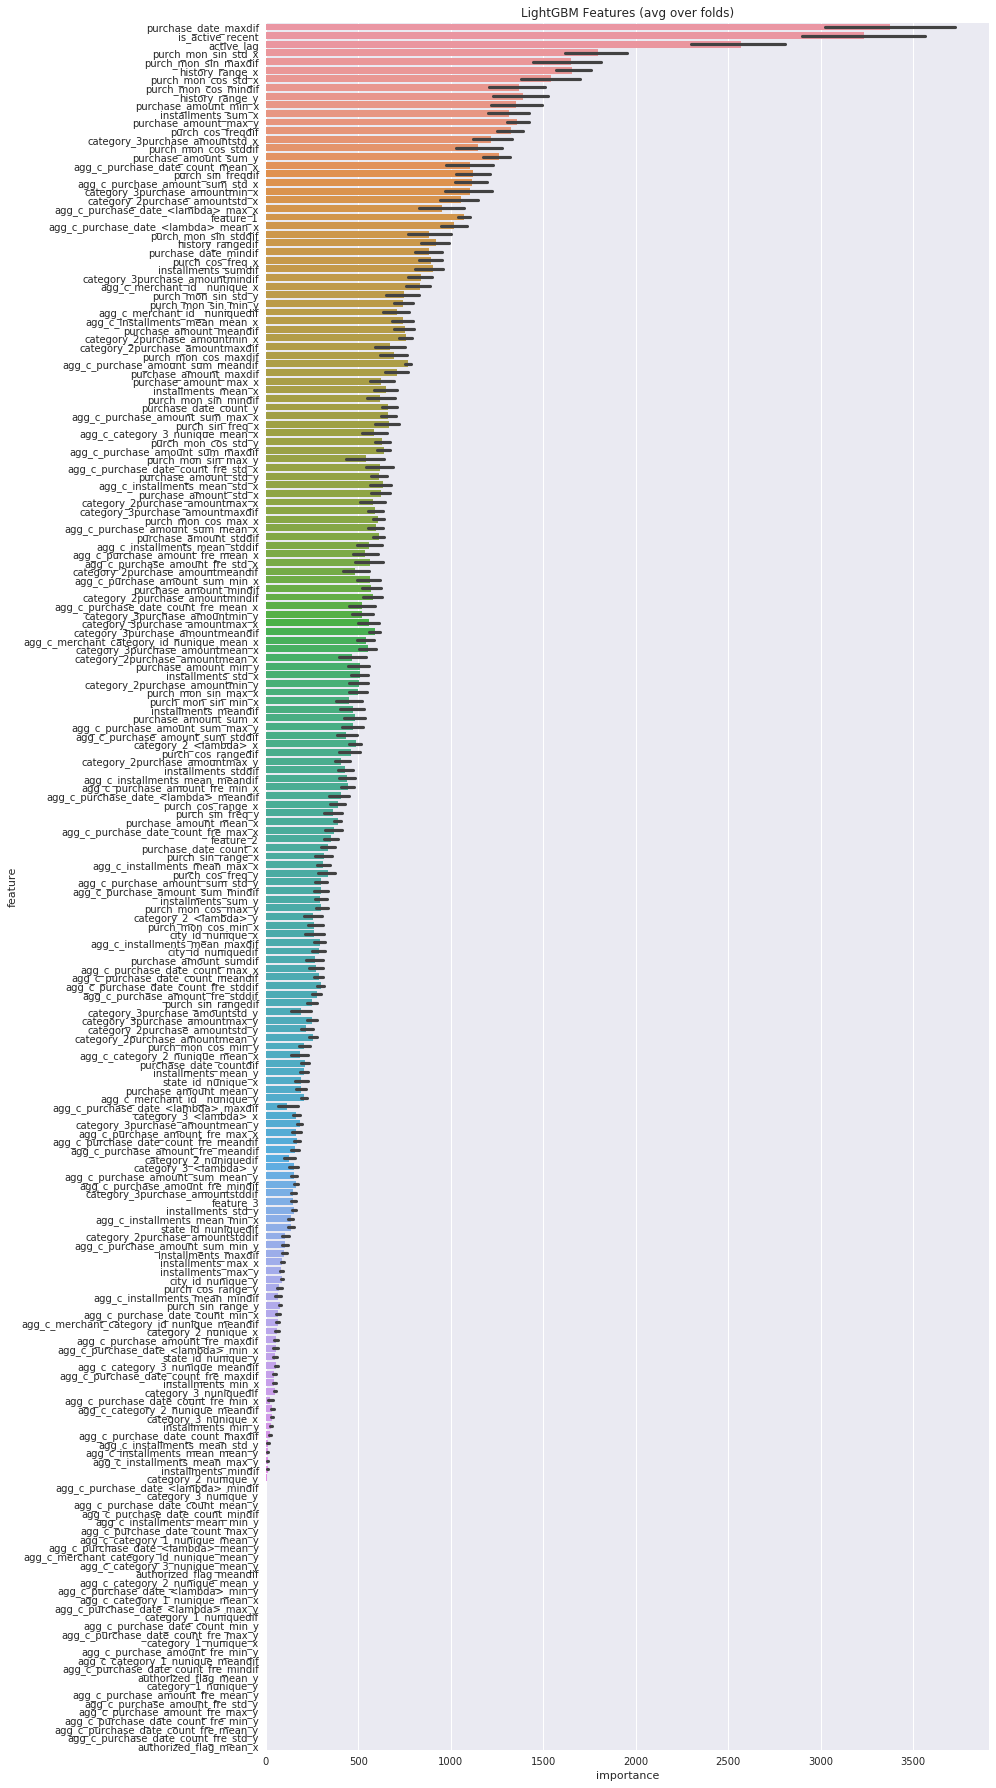

In [321]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [368]:
impt=feature_importance_df[["feature", "importance"]].groupby("feature").mean()
top_impt=impt['importance']>100
impt_feat=list(impt.loc[top_impt,:].reset_index()['feature'].values)


In [369]:
select=[c for c in features if c in impt_feat]

In [370]:
_,predictions=run_cv(select)

fold n°0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75755	valid_1's rmse: 3.81689
[200]	training's rmse: 3.70805	valid_1's rmse: 3.78624
[300]	training's rmse: 3.67494	valid_1's rmse: 3.77203
[400]	training's rmse: 3.65018	valid_1's rmse: 3.76499
[500]	training's rmse: 3.6308	valid_1's rmse: 3.76131
[600]	training's rmse: 3.61518	valid_1's rmse: 3.75945
[700]	training's rmse: 3.60181	valid_1's rmse: 3.75822
[800]	training's rmse: 3.59018	valid_1's rmse: 3.75777
[900]	training's rmse: 3.57937	valid_1's rmse: 3.75773
[1000]	training's rmse: 3.56919	valid_1's rmse: 3.75758
[1100]	training's rmse: 3.55967	valid_1's rmse: 3.75791
Early stopping, best iteration is:
[997]	training's rmse: 3.56949	valid_1's rmse: 3.75755
fold n°1


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.77417	valid_1's rmse: 3.74529
[200]	training's rmse: 3.72352	valid_1's rmse: 3.71826
[300]	training's rmse: 3.68895	valid_1's rmse: 3.70643
[400]	training's rmse: 3.66343	valid_1's rmse: 3.70024
[500]	training's rmse: 3.64325	valid_1's rmse: 3.69744
[600]	training's rmse: 3.62653	valid_1's rmse: 3.69556
[700]	training's rmse: 3.61258	valid_1's rmse: 3.69442
[800]	training's rmse: 3.60042	valid_1's rmse: 3.6936
[900]	training's rmse: 3.58861	valid_1's rmse: 3.69309
[1000]	training's rmse: 3.57782	valid_1's rmse: 3.69278
[1100]	training's rmse: 3.56777	valid_1's rmse: 3.69275
[1200]	training's rmse: 3.55822	valid_1's rmse: 3.69264
Early stopping, best iteration is:
[1028]	training's rmse: 3.57496	valid_1's rmse: 3.69255
fold n°2


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.78068	valid_1's rmse: 3.71677
[200]	training's rmse: 3.73021	valid_1's rmse: 3.68855
[300]	training's rmse: 3.69632	valid_1's rmse: 3.67569
[400]	training's rmse: 3.67085	valid_1's rmse: 3.6692
[500]	training's rmse: 3.65106	valid_1's rmse: 3.66619
[600]	training's rmse: 3.63486	valid_1's rmse: 3.66453
[700]	training's rmse: 3.62137	valid_1's rmse: 3.6637
[800]	training's rmse: 3.60888	valid_1's rmse: 3.66314
[900]	training's rmse: 3.59777	valid_1's rmse: 3.66313
[1000]	training's rmse: 3.58745	valid_1's rmse: 3.66315
[1100]	training's rmse: 3.57741	valid_1's rmse: 3.6631
[1200]	training's rmse: 3.56859	valid_1's rmse: 3.66337
Early stopping, best iteration is:
[1064]	training's rmse: 3.58076	valid_1's rmse: 3.66294
fold n°3


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.72967	valid_1's rmse: 3.92318
[200]	training's rmse: 3.68005	valid_1's rmse: 3.89559
[300]	training's rmse: 3.64612	valid_1's rmse: 3.88297
[400]	training's rmse: 3.62041	valid_1's rmse: 3.87733
[500]	training's rmse: 3.60059	valid_1's rmse: 3.87484
[600]	training's rmse: 3.58402	valid_1's rmse: 3.87356
[700]	training's rmse: 3.56999	valid_1's rmse: 3.87296
[800]	training's rmse: 3.55682	valid_1's rmse: 3.87297
[900]	training's rmse: 3.54559	valid_1's rmse: 3.87295
Early stopping, best iteration is:
[744]	training's rmse: 3.56343	valid_1's rmse: 3.87282
fold n°4


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.77457	valid_1's rmse: 3.73629
[200]	training's rmse: 3.72327	valid_1's rmse: 3.71238
[300]	training's rmse: 3.68857	valid_1's rmse: 3.70175
[400]	training's rmse: 3.66239	valid_1's rmse: 3.6971
[500]	training's rmse: 3.64222	valid_1's rmse: 3.69474
[600]	training's rmse: 3.62523	valid_1's rmse: 3.69388
[700]	training's rmse: 3.61126	valid_1's rmse: 3.6932
[800]	training's rmse: 3.59886	valid_1's rmse: 3.69314
[900]	training's rmse: 3.58801	valid_1's rmse: 3.69309
Early stopping, best iteration is:
[759]	training's rmse: 3.60384	valid_1's rmse: 3.693
CV score: 3.73653 


/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [372]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit3.csv", index=False)